### Steps:
1. Focus on **understanding what should be the label feature** (the y) if not provided explicitly.

2. `info()` & `describe()` on the dataset.

3. Handle missing/duplicated data.

4. **[Pandas Profiling](https://pandas-profiling.ydata.ai)** is nice to show.

5. Show a **pairplot** ([seaborn](https://seaborn.pydata.org/generated/seaborn.pairplot.html)) - how each feature is correlating with the label feature.

6. Pay attention to **leaks in the data**!<br>
It is forbidden to use users' events after they became the label == 1.<br>
For example, given actions' events of each user, we want to classify users by their features and predict which user will purchase a subscription (label == 1), we must not use the actions of a user after their purchase date. Only until they purchased.

7. **Filtering data:**<br>
Which users to keep in our dataset - if they have too few records, or they are too new (i.e. by their starting date).

8. **Filtering features:**<br>
Think what is interesting for the model.<br>
Also, think of new features to create by aggregating given features (i.e. number_of_logins_per_week).<br>
Show analysis for feature selection and explain your decisions.

9. Check data balance - the proportion of each class (after filtering the data).<br>
Either sample each class by the proportion of the smallest class or (better) use a DecisionTreeClassifier with `class_weight=="balanced"` ([here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)).

10. Normalize the data if needed.

11. Consider using `predict_proba` (to show precision vs. recall later and choose the optimal threshold for classification, depending on the business case).

12. Use cross-validation when fitting the data.

13. Visualize the Decision Tree.

14. Do Evaluation Analysis on results (Precision & Recall, F1 score, AUC).

15. Use `random_state` where needed for consistency.

16. Summarize results and conclusion.


### Notes:
1. Tree-based models don't require scaling of data.
2. There are some auto **feature selection** libraries worth considering.

# Imports

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Constants

In [151]:
CV = 4  # number of cross-validation sets

# Load data

In [152]:
col_names = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'pedigree', 'age', 'label']
df = pd.read_csv('diabetes.csv', names=col_names, header=None)
df.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,pedigree,age,label
0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0


In [153]:
# remove first row
df = df.drop(0, axis=0)

In [154]:
for c in ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'age', 'label']:
    df[c] = df[c].astype(int)

for c in ['bmi', 'pedigree']:
    df[c] = df[c].astype(float)

# Data Characteristics

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 1 to 768
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pregnancies     768 non-null    int32  
 1   glucose         768 non-null    int32  
 2   blood_pressure  768 non-null    int32  
 3   skin_thickness  768 non-null    int32  
 4   insulin         768 non-null    int32  
 5   bmi             768 non-null    float64
 6   pedigree        768 non-null    float64
 7   age             768 non-null    int32  
 8   label           768 non-null    int32  
dtypes: float64(2), int32(7)
memory usage: 33.1 KB


In [156]:
df.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,pedigree,age,label
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [157]:
# a simple check for duplicated rows
df.duplicated().sum()

0

# EDA
Getting to know your data.<br>
As usual the first step is to get to know the data:<br>
How many samples, what are the attributes, what are the missing data, etc.

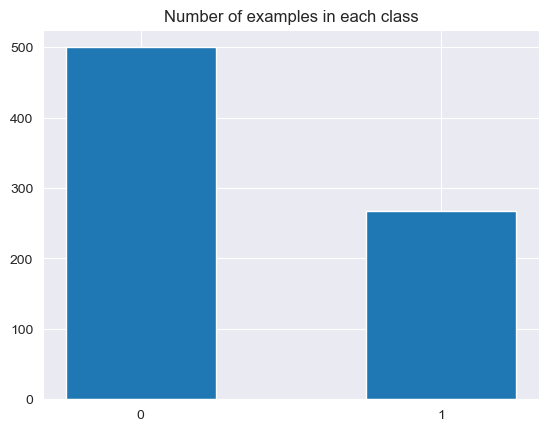

In [158]:
# number of examples in each class
plt.bar(df['label'].value_counts().index, df['label'].value_counts(), width=0.5)
plt.xticks(df['label'].value_counts().index)
plt.title('Number of examples in each class')
plt.show()

## Profiling
(optional)

In [159]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df)
# profile

## Plots

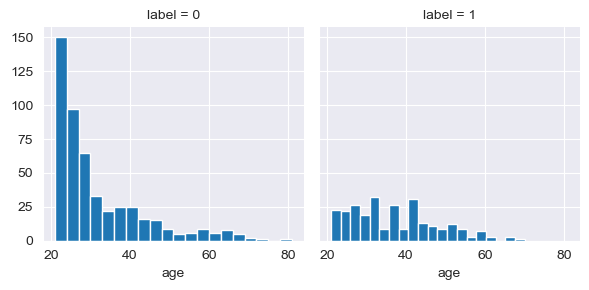

In [160]:
g = sns.FacetGrid(df, col='label')
g.map(plt.hist, 'age', bins=20)

`age` is a differentiating feature for the label, so we may take it into the model.

(19, 9)

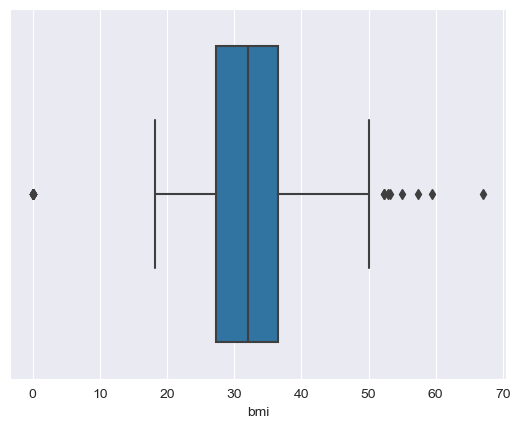

In [161]:
sns.boxplot(data=df, x='bmi')
bmi_iqr = np.percentile(df['bmi'], 75) - np.percentile(df['bmi'], 25)
lower_bound_bmi = np.percentile(df['bmi'], 25) - (1.5 * bmi_iqr)
upper_bound_bmi = np.percentile(df['bmi'], 75) + (1.5 * bmi_iqr)
df[(df['bmi'] > upper_bound_bmi) | (df['bmi'] < lower_bound_bmi)].shape

**Actions**:
1. Remove outliers in `bmi`.
2. `insulin` & `skin_thickness` are 0 for most samples, so we can drop these columns.
3. Impossible 0 `blood_pressure` & `glucose` values - remove these samples. 

## scatter plot

In [162]:
import plotly.express as px

# blue points -> negative class, yellow points -> positive class
fig = px.scatter_matrix(df, color='label')
fig.update_layout(
    title='Diabetes Data set',
    width=1000,
    height=1000,
)
fig.show()

## Bivariate Analysis

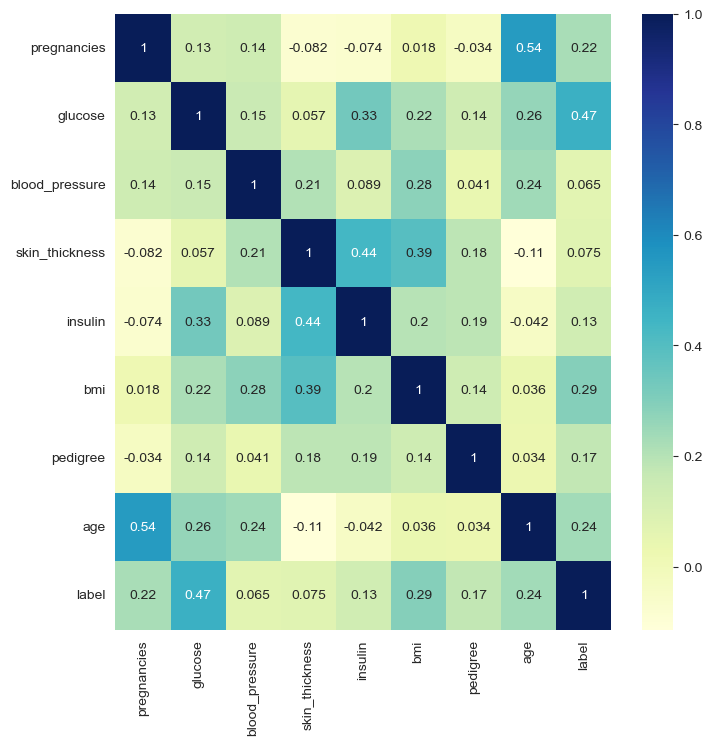

In [163]:
# plot correlation matrix between all predictors and label
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True)
plt.show()

# Data Cleansing
1. Drop irrelevant features.
2. Drop bad samples.

In [164]:
# 'insulin' and 'skin_thickness' are mostly 0, so we drop these features
drop_cols = ['insulin', 'skin_thickness']
df.drop(drop_cols, axis=1, inplace=True)

In [165]:
# drop bad samples
df.drop(df[(df['glucose'] == 0) |
           (df['blood_pressure'] == 0) |
           (df['bmi'] < lower_bound_bmi) |
           (df['bmi'] > upper_bound_bmi)]
        .index, inplace=True)

In [166]:
df.shape

(717, 7)

In [167]:
df.head()

,pregnancies,glucose,blood_pressure,bmi,pedigree,age,label
1,6,148,72,33.6,0.627,50,1
2,1,85,66,26.6,0.351,31,0
3,8,183,64,23.3,0.672,32,1
4,1,89,66,28.1,0.167,21,0
5,0,137,40,43.1,2.288,33,1


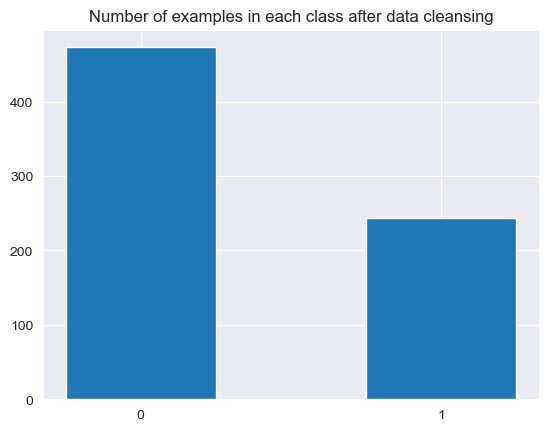

In [168]:
# number of examples in each class
plt.bar(df['label'].value_counts().index, df['label'].value_counts(), width=0.5)
plt.xticks(df['label'].value_counts().index)
plt.title('Number of examples in each class after data cleansing')
plt.show()

# Feature Engineering
Useful for providing more information to a model to improve its performance:
1. `age` into `age_group`

In [169]:
df['age_group'] = pd.cut(df['age'], 5)
df[['age_group', 'label']].groupby(['age_group'], as_index=False).mean().sort_values(by='age_group', ascending=True)

,age_group,label
0,"(20.94, 33.0]",0.243119
1,"(33.0, 45.0]",0.487952
2,"(45.0, 57.0]",0.573333
3,"(57.0, 69.0]",0.342105
4,"(69.0, 81.0]",0.500000


In [170]:
df.head()

,pregnancies,glucose,blood_pressure,bmi,pedigree,age,label,age_group
1,6,148,72,33.6,0.627,50,1,"(45.0, 57.0]"
2,1,85,66,26.6,0.351,31,0,"(20.94, 33.0]"
3,8,183,64,23.3,0.672,32,1,"(20.94, 33.0]"
4,1,89,66,28.1,0.167,21,0,"(20.94, 33.0]"
5,0,137,40,43.1,2.288,33,1,"(20.94, 33.0]"


In [171]:
df.loc[df['age'] <= 33, 'age'] = 0
df.loc[(df['age'] > 33) & (df['age'] <= 45), 'age'] = 1
df.loc[(df['age'] > 45) & (df['age'] <= 57), 'age'] = 2
df.loc[(df['age'] > 57) & (df['age'] <= 69), 'age'] = 3
df.loc[df['age'] > 69, 'age'] = 4
df.head()

,pregnancies,glucose,blood_pressure,bmi,pedigree,age,label,age_group
1,6,148,72,33.6,0.627,2,1,"(45.0, 57.0]"
2,1,85,66,26.6,0.351,0,0,"(20.94, 33.0]"
3,8,183,64,23.3,0.672,0,1,"(20.94, 33.0]"
4,1,89,66,28.1,0.167,0,0,"(20.94, 33.0]"
5,0,137,40,43.1,2.288,0,1,"(20.94, 33.0]"


In [172]:
# we can now remove the age_group feature
df = df.drop(['age_group'], axis=1)
df.head()

,pregnancies,glucose,blood_pressure,bmi,pedigree,age,label
1,6,148,72,33.6,0.627,2,1
2,1,85,66,26.6,0.351,0,0
3,8,183,64,23.3,0.672,0,1
4,1,89,66,28.1,0.167,0,0
5,0,137,40,43.1,2.288,0,1


# Preparing the data for model

In [211]:
X = df.drop('label', axis=1)
y = df['label']

In [212]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building classifiers

In [213]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

models = {
    'LR': LogisticRegression(random_state=42),
    'DT': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC()
}

In [214]:
for model_name, model in models.items():
    print(model_name + ":")
    cv_scores = cross_val_score(model, X_train, y_train, cv=CV)
    print(cv_scores)
    print("mean accuracy score:", cv_scores.mean())
    print("\n")

LR:
[0.75       0.70629371 0.8041958  0.81118881]
mean accuracy score: 0.7679195804195804


DT:
[0.74305556 0.64335664 0.66433566 0.72727273]
mean accuracy score: 0.6945051476301476


RF:


C:\Users\neshe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[0.78472222 0.71328671 0.77622378 0.7972028 ]
mean accuracy score: 0.7678588772338772


KNN:
[0.74305556 0.66433566 0.73426573 0.77622378]
mean accuracy score: 0.7294701825951826


SVM:
[0.75694444 0.6993007  0.7972028  0.78321678]
mean accuracy score: 0.759166181041181




Focusing on the `DecisionTreeClassifier`, we get:

In [243]:
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(class_weight='balanced',
                             random_state=42,
                             max_depth=6
                             )
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_score(y_test, predictions)

0.7083333333333334

# Visualizing the best Decision Tree

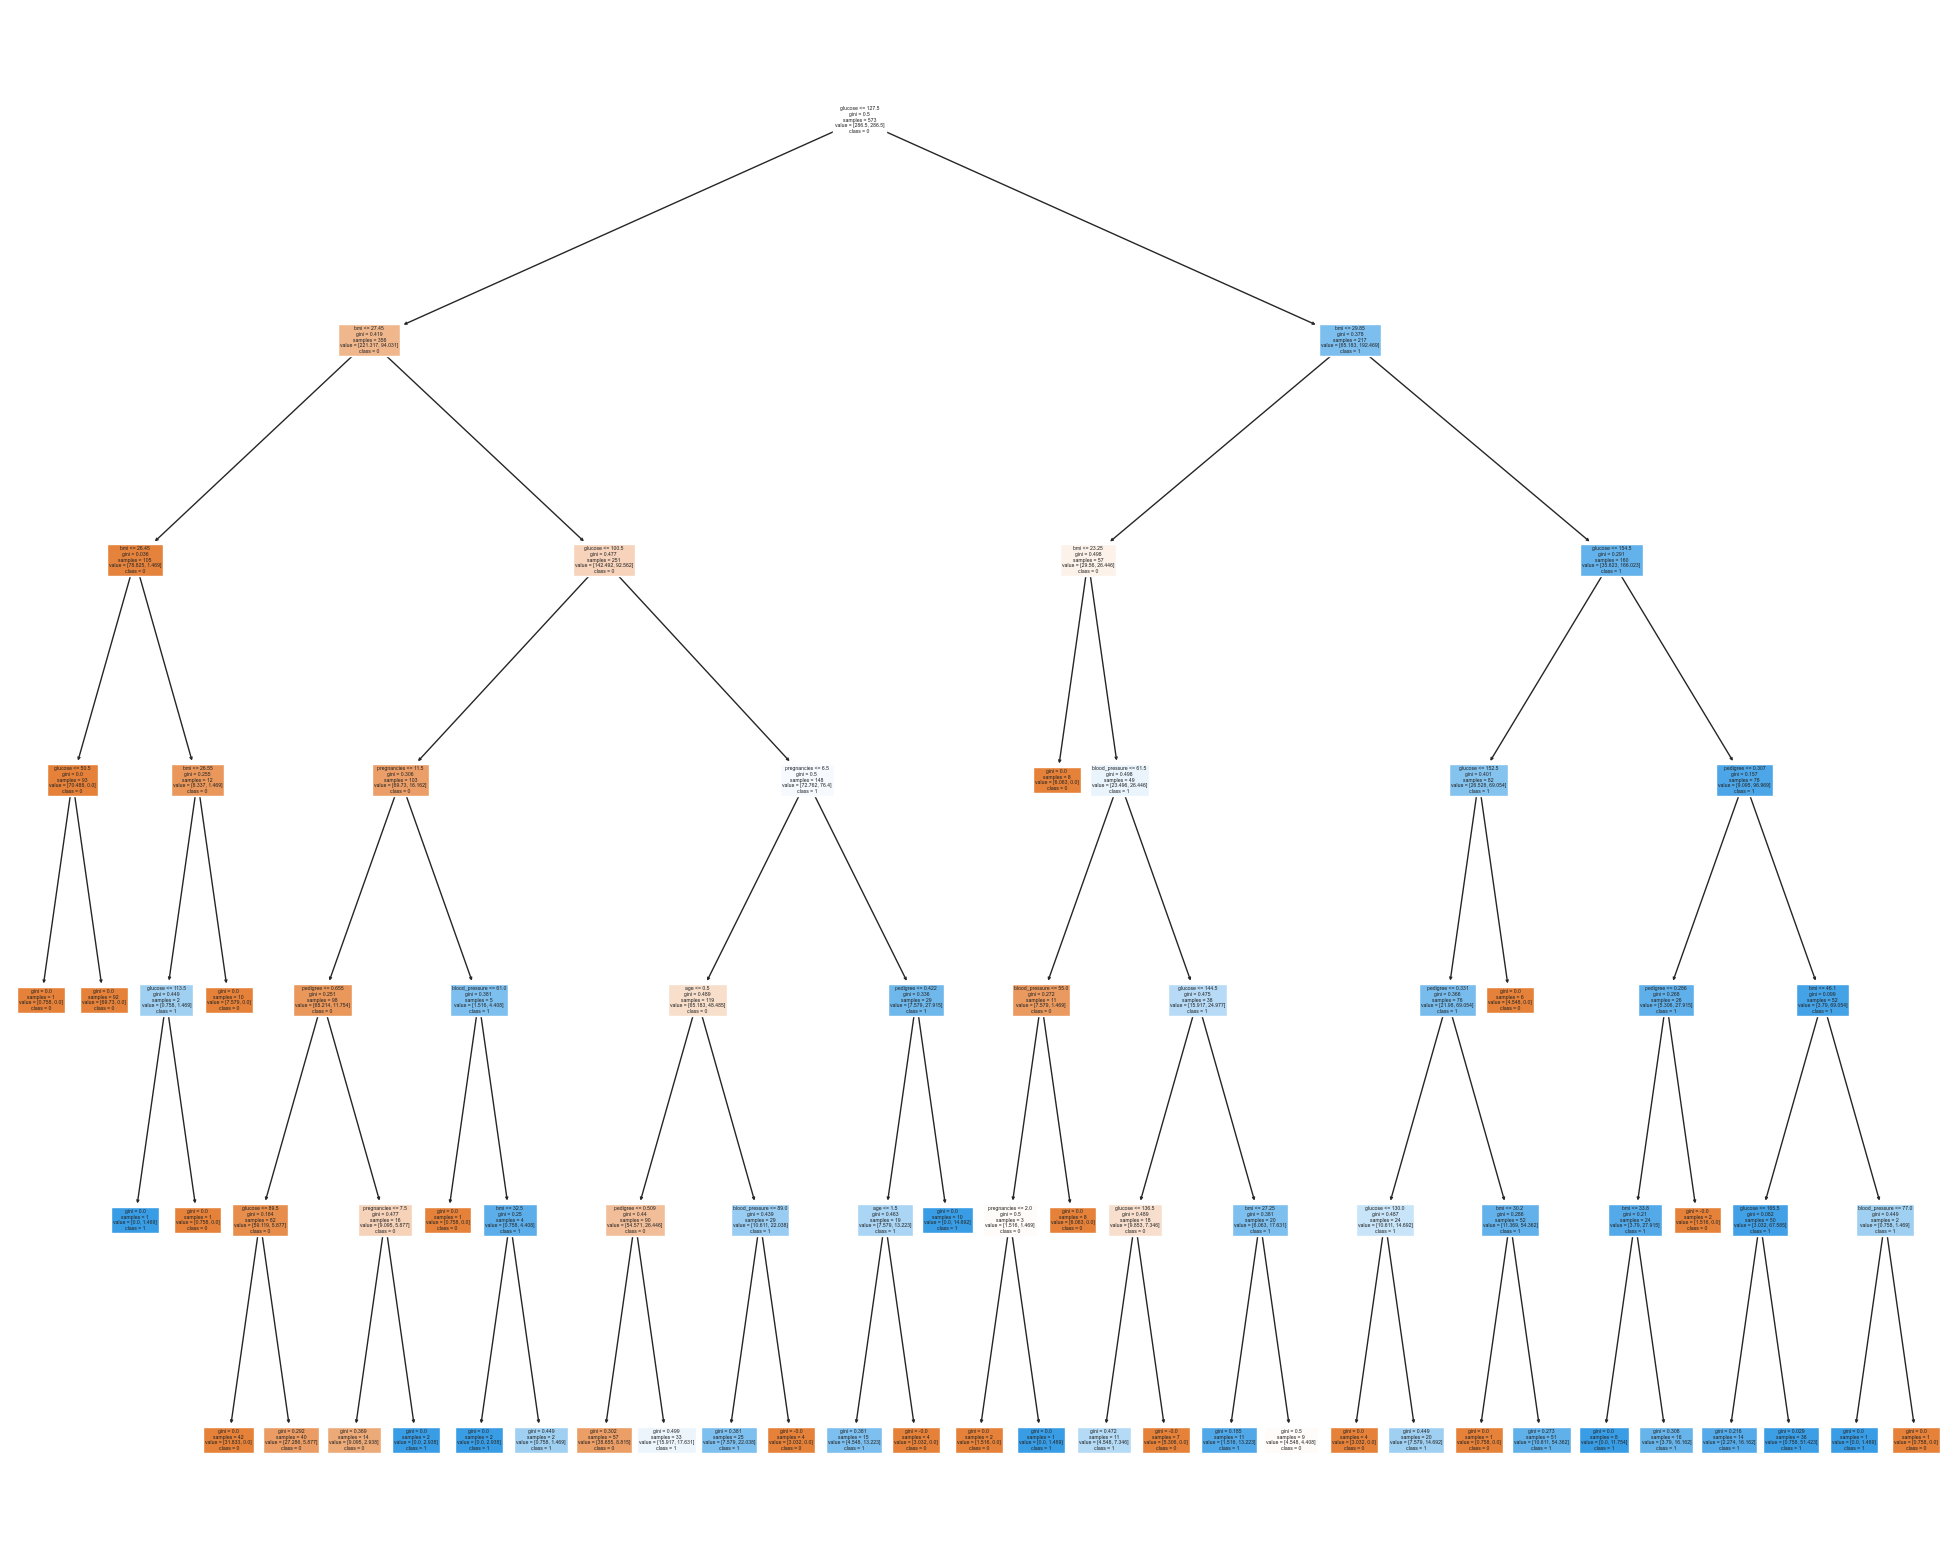

In [244]:
from sklearn import tree

fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(clf,
                   feature_names=list(X.columns),
                   class_names=['0', '1'],
                   filled=True)

In [245]:
fig.savefig('decision_tree.svg')

# Model Performance (Evaluation Analysis)

In [246]:
# model's accuracy, how often is the classifier correct?
y_pred = clf.predict(X_test)
print('Test set accuracy:', round(accuracy_score(y_test, y_pred), 4))

Test set accuracy: 0.7083


In [247]:
# these are the probabilities of each class for every sample in the test data
y_pred_proba = clf.predict_proba(X_test)
y_pred_proba

array([[0.5078125 , 0.4921875 ],
       [0.01452514, 0.98547486],
       [1.        , 0.        ],
       [0.47445255, 0.52554745],
       [1.        , 0.        ],
       [0.82278481, 0.17721519],
       [0.75581395, 0.24418605],
       [0.16331658, 0.83668342],
       [0.25590551, 0.74409449],
       [0.81429624, 0.18570376],
       [1.        , 0.        ],
       [0.47445255, 0.52554745],
       [0.01452514, 0.98547486],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.47445255, 0.52554745],
       [0.38235294, 0.61764706],
       [0.81429624, 0.18570376],
       [1.        , 0.        ],
       [0.16331658, 0.83668342],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.25590551, 0.74409449],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.25590551, 0.74409449],
       [0.

## Confusion Matrix

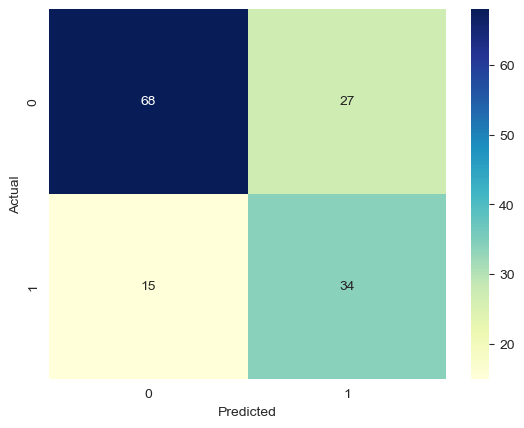

In [248]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), cmap='YlGnBu', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [249]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.72      0.76        95
           1       0.56      0.69      0.62        49

    accuracy                           0.71       144
   macro avg       0.69      0.70      0.69       144
weighted avg       0.73      0.71      0.71       144



## AUC curve

In [257]:
from sklearn.metrics import roc_curve, roc_auc_score

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_proba[:, 1])
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

AUC: 0.705


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.705


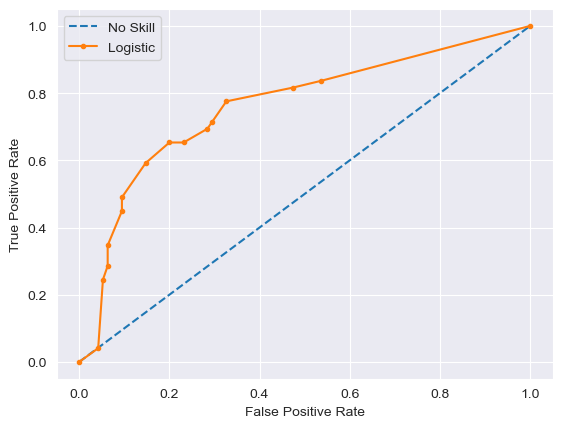

In [258]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % ns_auc)
print('Logistic: ROC AUC=%.3f' % auc)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(false_positive_rate, true_positive_rate, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Results & conclusions

* We went over the process of building a basic classifier and the whole process of handling the data, EDA, fitting a model, and evaluating its results.
* We ended up with a basic DecisionTreeClassifier with ~70% accuracy, which is not great but there is a lot to improve.
